In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [81]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv"
)
df["ds"] = pd.to_datetime(df["ds"]).dt.to_period("D")
y = df.set_index("ds")
display(y)

,y
ds,
2007-12-10,9.590761
2007-12-11,8.519590
2007-12-12,8.183677
2007-12-13,8.072467
2007-12-14,7.893572
...,...
2016-01-16,7.817223
2016-01-17,9.273878
2016-01-18,10.333775


In [82]:
import numpy as np
def _make_fake_effect(y):
    
    
    x = np.abs(np.cumsum(np.random.randn(len(y))))
    x = x/np.max(x)
    effect = (1/(1 + (x/0.2)**-1.2)).reshape((-1, 1))
    y = y+effect.reshape((-1, 1))
    return x, effect, y

x_effect, effect, y = _make_fake_effect(y)

In [83]:
y

,y
ds,
2007-12-10,9.601718
2007-12-11,8.587485
2007-12-12,8.268658
2007-12-13,8.133478
2007-12-14,7.946759
...,...
2016-01-16,8.281660
2016-01-17,9.692371
2016-01-18,10.794238


<Axes: xlabel='ds'>

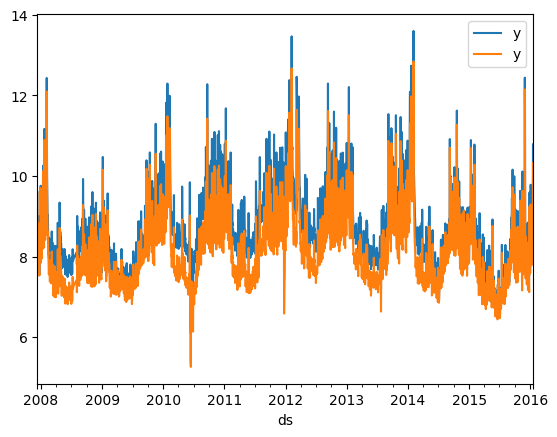

In [84]:
ax=  y.plot.line()
(y - effect).plot.line(ax=ax)

In [85]:

t = (y.index.to_timestamp() - y.index.to_timestamp().min()).days.values
t = jnp.array(t).reshape(-1, 1)
y_array = jnp.array(y.values).reshape(-1, 1)
y_array

Array([[ 9.601718],
       [ 8.587485],
       [ 8.268658],
       ...,
       [10.794237],
       [ 9.638514],
       [ 9.42002 ]], dtype=float32)

In [86]:
from sktime.transformations.series.fourier import FourierFeatures

X = FourierFeatures(sp_list=[7, 365.25], fourier_terms_list=[3, 10]).fit_transform(y=y_array, X=pd.DataFrame(index=y.index)).values
X = jnp.array(X)
X.shape

(2905, 26)

In [174]:
def get_changepoint_matrix(t, changepoint_t):

    expanded_ts = jnp.tile(t.reshape((-1, 1)), (1, len(changepoint_t)))
    A = (expanded_ts >= changepoint_t.reshape((1, -1))).astype(
        int
    ) * expanded_ts
    cutoff_ts = changepoint_t.reshape((1, -1))
    A = jnp.clip(A - cutoff_ts + 1, 0, None)
    return A

def get_changepoint_timeindexes(t, changepoint_interval : int, changepoint_range : float=0.90):
    len_t = len(t)
    max_t = t.max() * changepoint_range
    changepoint_t = np.arange(0, max_t, changepoint_interval)
    return changepoint_t



In [175]:
changepoint_t = get_changepoint_timeindexes(t, changepoint_interval=350)
changepoint_matrix = get_changepoint_matrix(t=t, changepoint_t=changepoint_t)

## Code

### Inference Engine

In [88]:
from typing import Callable
import numpyro
from numpyro.infer.initialization import init_to_mean
from numpyro.infer import SVI, TraceEnum_ELBO, init_to_value, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta
import jax


class InferenceEngine:

    def __init__(self, model: Callable, rng_key=None):
        self.model = model
        if rng_key is None:
            rng_key = jax.random.PRNGKey(0)
        self.rng_key = rng_key

    def infer(self, **kwargs): ...

    def predict(self, **kwargs): ...


class MAPInferenceEngine(InferenceEngine):

    def __init__(
        self,
        model: Callable,
        optimizer: numpyro.optim._NumPyroOptim = None,
        num_steps=10000,
        rng_key=None,
    ):
        if optimizer is None:
            optimizer = numpyro.optim.Adam(step_size=0.001)
        self.optimizer = optimizer
        self.num_steps = num_steps
        super().__init__(model, rng_key)

    def infer(self, **kwargs):
        self.guide_ = AutoDelta(self.model, init_loc_fn=init_to_mean())
        self.svi_ = SVI(self.model, self.guide_, self.optimizer, loss=Trace_ELBO())
        self.run_results_ = self.svi_.run(
            rng_key=self.rng_key, num_steps=self.num_steps, **kwargs
        )
        return self

    def predict(self, **kwargs):
        predictive = numpyro.infer.Predictive(
            self.model,
            params=self.run_results_.params,
            num_samples=1000,
            guide=self.guide_,
        )
        self.samples_ = predictive(
            **{**kwargs, "y": None},
            rng_key=self.rng_key,
        )
        return self.samples_


class MCMCInferenceEngine(InferenceEngine):

    def __init__(
        self,
        model: Callable,
        num_samples=1000,
        num_warmup=200,
        dense_mass=False,
        rng_key=None,
    ):
        self.num_samples = num_samples
        self.num_warmup = num_warmup
        self.dense_mass = dense_mass
        super().__init__(model, rng_key)

    def infer(self, **kwargs):
        self.mcmc_ = MCMC(
            NUTS(self.model, dense_mass=self.dense_mass, init_strategy=init_to_mean()),
            num_samples=self.num_samples,
            num_warmup=self.num_warmup,
        )
        self.mcmc_.run(self.rng_key, **kwargs)
        return self

    def predict(self, **kwargs):
        self.samples_ = self.mcmc_.get_samples()
        return self.samples_

### Model

In [147]:
import sys

#  pylint: disable=g-import-not-at-top
from typing import Protocol, TypedDict, Dict, Tuple


import jax.numpy as jnp
import numpyro
from numpyro import distributions as dist


class EffectFunc(Protocol):

    def __call__(
        self, trend: jnp.ndarray, data: jnp.ndarray, coefficients: jnp.ndarray
    ) -> jnp.ndarray: ...

class SampleParamsFunc(Protocol):
    
    def __call__(self, **kwargs) -> jnp.ndarray: ...


class ExogenousEffects(TypedDict):
    data: jnp.ndarray
    transformation_func: EffectFunc
    sample_params_func: SampleParamsFunc


def matrix_multiplication(data, coefficients):
    return data @ coefficients.reshape((-1, 1))


def additive_effect(
    trend: jnp.ndarray, data: jnp.ndarray, coefficients: jnp.ndarray
) -> jnp.ndarray:
    return matrix_multiplication(data, coefficients)


def multiplicative_effect(
    trend: jnp.ndarray, data: jnp.ndarray, coefficients: jnp.ndarray
) -> jnp.ndarray:
    return trend * matrix_multiplication(data, coefficients)


def apply_exponent_safe(
    data: jnp.ndarray,
    exponent: jnp.ndarray,
) -> jnp.ndarray:
    """Applies an exponent to given data in a gradient safe way.

    More info on the double jnp.where can be found:
    https://github.com/tensorflow/probability/blob/main/discussion/where-nan.pdf

    Args:
      data: Input data to use.
      exponent: Exponent required for the operations.

    Returns:
      The result of the exponent operation with the inputs provided.
    """
    exponent_safe = jnp.where(data == 0, 1, data) ** exponent
    return jnp.where(data == 0, 0, exponent_safe)


def hill(
    trend : jnp.ndarray,
    data: jnp.ndarray, 
    coefficients : Tuple[jnp.ndarray, jnp.ndarray]
) -> jnp.ndarray:
    """Calculates the hill function for a given array of values.

    Refer to the following link for detailed information on this equation:
      https://en.wikipedia.org/wiki/Hill_equation_(biochemistry)

    Args:
      data: Input data.
      half_max_effective_concentration: ec50 value for the hill function.
      slope: Slope of the hill function.

    Returns:
      The hill values for the respective input data.
    """
    half_max_effective_concentration, slope = coefficients
    save_transform = apply_exponent_safe(
        data=data / half_max_effective_concentration, exponent=-slope
    )
    return jnp.where(save_transform == 0, 0, 1.0 / (1 + save_transform))

def _sample_hill_params():
    
    half_max_effective_concentration = numpyro.sample(
        "half_max_effective_concentration",
        dist.Gamma(concentration=1, rate=1) 
    )
    
    slope = numpyro.sample(
        "slope",
        dist.Gamma(concentration=1, rate=1) 
    )
    
    return (half_max_effective_concentration, slope)


# Log

def log_effect(
    trend: jnp.ndarray, data: jnp.ndarray, coefficients: jnp.ndarray
) -> jnp.ndarray:
    
    scale, rate = coefficients
    return scale*jnp.log(rate*data + 1)

def _sample_log_params():
    
    scale = numpyro.sample(
        "scale",
        dist.Gamma(concentration=1, rate=1) 
    )
    
    rate = numpyro.sample(
        "rate",
        dist.Gamma(concentration=1, rate=1) 
    )
    
    return (scale, rate)

In [194]:
from abc import ABC, abstractmethod


class AbstractEffect(ABC):

    def __init__(self, id=""):
        self.id = id

    @abstractmethod
    def sample(self):
        raise NotImplementedError()

    @abstractmethod
    def get_effect(self, trend, data, coefficients): ...

    def __call__(self, trend, data):

        coefficients = self.sample()
        return self.get_effect(trend, data, coefficients)


class LogEffect(AbstractEffect):

    def __init__(self, id=""):
        super().__init__(id)

    def sample(self):
        scale = numpyro.sample(f"{self.id}scale", dist.Gamma(concentration=1, rate=1))

        rate = numpyro.sample(f"{self.id}rate", dist.Gamma(concentration=1, rate=1))

        return (scale, rate)

    def get_effect(self, trend, data, coefficients):
        return log_effect(trend, data, coefficients)


class AdditiveEffect(AbstractEffect):

    def __init__(self, id="", n_features=1, prior_loc=0, prior_scale=0.1):
        self.n_features = n_features
        self.prior_loc = prior_loc
        self.prior_scale = prior_scale
        super().__init__(id)

    def sample(self):
        return numpyro.sample(
            "coefs",
            dist.Normal(
                jnp.array([self.prior_loc] * self.n_features),
                jnp.array([self.prior_scale] * self.n_features),
            ),
        )

    def get_effect(self, trend, data, coefficients):
        return additive_effect(trend, data, coefficients)


class MultiplicativeEffect(AbstractEffect):

    def __init__(self, id="", n_features=1, prior_loc=0, prior_scale=0.1):
        self.n_features = n_features
        self.prior_loc = prior_loc
        self.prior_scale = prior_scale
        super().__init__(id)

    def sample(self):
        return numpyro.sample(
            "coefs",
            dist.Normal(
                jnp.array([self.prior_loc] * self.n_features),
                jnp.array([self.prior_scale] * self.n_features),
            ),
        )

    def get_effect(self, trend, data, coefficients):
        return multiplicative_effect(trend, data, coefficients)

In [195]:
def model(
    t,
    y,
    changepoint_matrix,
    init_trend_params,
    trend_mode,
    exogenous_effects: Dict[str, ExogenousEffects],
    y_scale: float,
    data = {}
):
    """
    Defines the Numpyro model.

    Args:
        y (jnp.ndarray): Array of time series data.
        X (jnp.ndarray): Array of exogenous variables.
        t (jnp.ndarray): Array of time values.
    """
    params = init_trend_params()

    # Trend
    changepoint_coefficients = params["changepoint_coefficients"]
    offset = params["offset"]
    capacity = params.get("capacity", None)

    trend = (changepoint_matrix) @ changepoint_coefficients.reshape((-1, 1)) + offset
    if trend_mode == "logistic":
        trend = capacity / (1 + jnp.exp(-trend))

    trend = trend * y_scale

    numpyro.deterministic("trend_", trend)

    mean = trend
    # Exogenous effects
    if exogenous_effects is not None:

        for key, exog_effect in exogenous_effects.items():
            
            exog_data = data[key]
            effect = exog_effect(
                trend=trend, data=exog_data
            )
            numpyro.deterministic(key, effect)
            mean += effect

    noise_scale = params["std_observation"] * y_scale

    with numpyro.plate("data", len(mean), dim=-2) as time_plate:
        numpyro.sample(
            "obs",
            dist.Normal(mean.reshape((-1, 1)), noise_scale),
            obs=y,
        )

In [197]:
def init_trend_params():
    return {
        "changepoint_coefficients": numpyro.sample(
            "changepoint_coefficients",
            dist.Laplace(
                jnp.array([0] * len(changepoint_t)),
                jnp.array([1e-3] * len(changepoint_t)),
            ),
        ),
        "offset": numpyro.sample("offset", dist.Normal(0.4, 2)),
        "std_observation": numpyro.sample("std_observation", dist.HalfNormal(0.1)),
    }


model_inputs = dict(
    t=t,
    y=y_array,
    changepoint_matrix=changepoint_matrix,
    init_trend_params=init_trend_params,
    data={"seasonality": X, "hill": jnp.array(x_effect).reshape((-1, 1))},
    exogenous_effects={
        "seasonality": MultiplicativeEffect(id="seasonality", n_features=X.shape[1]),
        "hill": LogEffect(),
    },
    # exogenous_effects=None,
    trend_mode="linear",
    y_scale=y_array.max(),
)


engine = MAPInferenceEngine(
    model, optimizer=numpyro.optim.Adam(step_size=0.0001), num_steps=100000
)
engine.infer(**model_inputs)
svi_samples = engine.predict(**model_inputs)

100%|██████████| 100000/100000 [00:10<00:00, 9258.98it/s, init loss: 96463392.0000, avg. loss [95001-100000]: 2346.7996]


In [179]:
engine.run_results_.params

{'changepoint_coefficients_auto_loc': Array([-1.4154938e-04,  3.0994951e-04, -1.9711193e-04,  1.1798885e-04,
        -6.7863664e-05, -7.7319906e-05, -3.4818097e-06, -1.3621796e-05],      dtype=float32),
 'coefs_auto_loc': Array([ 0.00975809,  0.02282425, -0.00129973,  0.01939639, -0.00556887,
        -0.00028115, -0.01284599,  0.08741046,  0.0081553 , -0.01544626,
         0.02825055, -0.00784745,  0.00026138, -0.01511114, -0.01061948,
        -0.00238327, -0.0136605 , -0.00266839, -0.006447  ,  0.00512845,
         0.00661492,  0.01289693,  0.00039717, -0.00195147, -0.00943267,
        -0.00631547], dtype=float32),
 'offset_auto_loc': Array(0.60961425, dtype=float32),
 'rate_auto_loc': Array(2.773814, dtype=float32),
 'scale_auto_loc': Array(0.5867382, dtype=float32),
 'std_observation_auto_loc': Array(0.04077386, dtype=float32)}

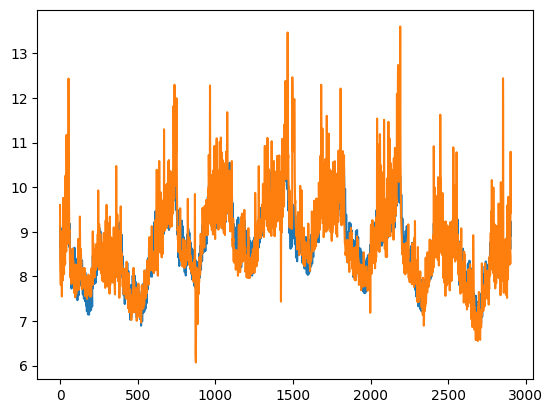

In [180]:

plt.plot(svi_samples["obs"].mean(axis=0).squeeze())
plt.plot(y_array.squeeze())

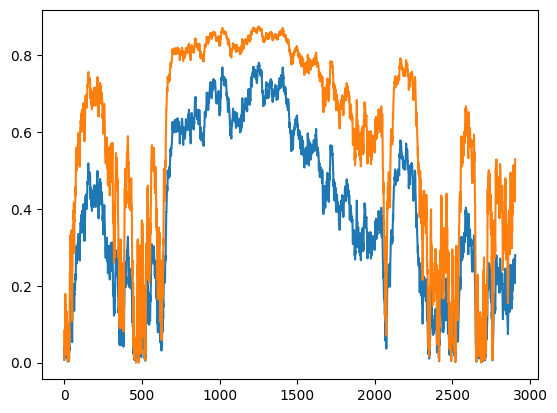

In [181]:
plt.plot(svi_samples["hill"].mean(axis=0).squeeze())
plt.plot(effect)